#### Import Libraries

This is to import all the libraries that are going to be used for the project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import tensorflow as tf
from tensorflow.keras import Sequential    # import Sequential from tensorflow.keras
from tensorflow.keras.layers import Dense  # import Dense from tensorflow.keras.layers
from numpy.random import seed     # seed helps you to fix the randomness in the neural network.  
from tensorflow import keras
#import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import scipy as sc
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
#import smogn
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from scipy.stats import randint
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
import xgboost as xg
import sqlite3

#### EDA

We read ASIN data with encoding 'latin-1' because of words with accents.

In [2]:
df2 = pd.read_csv('https://spainbox.com/SDCO.csv', encoding = 'latin-1')
df2.head()

,Date,ASIN,TaxCode,Name,Qty,RegularPrice,Total Discount,Sale Price,Perc. Discount,Cost
0,2019-01-13,B00FWSK1UE,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,2,57.84,57.84,0.0,0,23.52
1,2019-01-13,B00FYU5QRI,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,3,90.48,90.48,0.0,0,35.28
2,2019-01-13,B01N1YYIVZ,A_GEN_STANDARD,SD Codefree - Estuche que contiene Monitor de ...,6,290.04,290.04,0.0,0,46.00
3,2019-01-14,B00FWSK1UE,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,1,28.92,28.92,0.0,0,11.76
4,2019-01-14,B00FYU5QRI,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,1,30.16,30.16,0.0,0,11.76


We can observe that there are error in the values for some columns such as Total Discount and Sale Price. To fix Totall Discount we multiply the Regular price with (The Perc. Discount / 100). For Sale Price we substract Total Discount from RegularPrice.

In [3]:
df2['Total Discount'] = df2['RegularPrice'] * (df2['Perc. Discount']/100)
df2['Sale Price'] = df2['RegularPrice'] - df2['Total Discount']

In [4]:
df2['TaxCode'].unique()

array(['A_GEN_STANDARD', 'A_HPC_SANITARYPRODUCTS', 'A_GEN_REDUCED'],
      dtype=object)

For the presented data we can see there are no null values, so no need to fill.

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            668 non-null    object 
 1   ASIN            668 non-null    object 
 2   TaxCode         668 non-null    object 
 3   Name            668 non-null    object 
 4   Qty             668 non-null    int64  
 5   RegularPrice    668 non-null    float64
 6   Total Discount  668 non-null    float64
 7   Sale Price      668 non-null    float64
 8   Perc. Discount  668 non-null    int64  
 9   Cost            668 non-null    float64
dtypes: float64(4), int64(2), object(4)
memory usage: 52.3+ KB


By describing the data we can see that the Percentage Discount has a mean of 1.53% and a max of 30%. Quantity purchased varies from 1 to 30.

In [6]:
df2.describe()

,Qty,RegularPrice,Total Discount,Sale Price,Perc. Discount,Cost
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,4.517964,158.758907,1.183165,157.575742,1.537425,44.675120
std,4.519620,222.126337,6.821031,222.236976,5.245125,41.495689
min,1.000000,17.170000,0.000000,17.170000,0.000000,11.760000
25%,1.000000,28.360000,0.000000,28.360000,0.000000,11.760000
50%,3.000000,80.430000,0.000000,76.320000,0.000000,23.520000
75%,6.000000,152.640000,0.000000,152.640000,0.000000,69.000000
max,30.000000,1595.100000,140.688000,1595.100000,30.000000,230.000000


We do some feature engineer for dates by getting individual columns like day, month, year, etc.

In [7]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2['day'] = df2['Date'].dt.day
df2['week_of_year'] = df2['Date'].dt.isocalendar().week
df2['month'] = df2['Date'].dt.month
df2['month_start'] = df2['Date'].dt.is_month_start
df2['month_end'] = df2['Date'].dt.is_month_end
df2['year'] = df2['Date'].dt.year
df2['quarter'] = df2['Date'].dt.quarter

Add Sales Column to analyze, we are not going to use Sales it is dependent from Quantity, which is what we are going to predict with Machine Learning.

In [8]:
df2['Sales'] = df2['Sale Price'] * df2['Qty']

In [9]:
df2 = df2.sort_values(by='Date')
df2.head()

,Date,ASIN,TaxCode,Name,Qty,RegularPrice,Total Discount,Sale Price,Perc. Discount,Cost,day,week_of_year,month,month_start,month_end,year,quarter,Sales
0,2019-01-13,B00FWSK1UE,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,2,57.84,0.0,57.84,0,23.52,13,2,1,False,False,2019,1,115.68
1,2019-01-13,B00FYU5QRI,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,3,90.48,0.0,90.48,0,35.28,13,2,1,False,False,2019,1,271.44
2,2019-01-13,B01N1YYIVZ,A_GEN_STANDARD,SD Codefree - Estuche que contiene Monitor de ...,6,290.04,0.0,290.04,0,46.00,13,2,1,False,False,2019,1,1740.24
3,2019-01-14,B00FWSK1UE,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,1,28.92,0.0,28.92,0,11.76,14,3,1,False,False,2019,1,28.92
4,2019-01-14,B00FYU5QRI,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,1,30.16,0.0,30.16,0,11.76,14,3,1,False,False,2019,1,30.16


In [10]:
#df2['discount_bool'] = np.where(df2['Perc. Discount'] > 0, True, False)

Load reviews data. This is important to see the impact of reviews with purchases, values of ratings have a max of 5 stars.

In [11]:
ratings = pd.read_csv('/content/SDCODEFREE_reviews.csv')
ratings = ratings.drop(columns= (ratings.columns)[3:])
ratings.head()

,a_asin,a_date,rating
0,B00FWSK1UE,2013-12-02,4
1,B00FWSK1UE,2013-12-31,4
2,B00FWSK1UE,2014-01-08,5
3,B00FWSK1UE,2014-03-29,4
4,B00FWSK1UE,2014-03-31,5


To properly match reviews data with ASIN data, we have to merge them by Dates. If we match them by exact dates there are going to be a lot of missing values. For this, a group by per month and year was done getting the mean value. After doing this, we merge based on ASIN, month and year. First we change the Date datatype to Datetime.

In [12]:
ratings['a_date'] = pd.to_datetime(ratings['a_date'])
ratings = ratings.rename(columns={'a_asin': 'ASIN', 'a_date': 'Date'})

In [13]:
ratings['month'] = ratings['Date'].dt.month
ratings['year'] = ratings['Date'].dt.year
ratings = ratings.drop(columns = 'Date')

In [14]:
ratings = ratings.groupby(by = ['ASIN', 'month', 'year']).mean().reset_index()
ratings

,ASIN,month,year,rating
0,B00FWSK1UE,1,2014,5.000000
1,B00FWSK1UE,1,2017,5.000000
2,B00FWSK1UE,1,2019,4.000000
3,B00FWSK1UE,2,2015,5.000000
4,B00FWSK1UE,2,2016,5.000000
...,...,...,...,...
148,B088LQWL3P,10,2020,5.000000
149,B088LQWL3P,10,2021,5.000000
150,B088LQWL3P,11,2020,4.666667
151,B088LQWL3P,12,2020,4.500000


In [15]:
df2 = pd.merge(df2, ratings, how = 'left', on = ['ASIN', 'month', 'year'])
df2.columns

Index(['Date', 'ASIN', 'TaxCode', 'Name', 'Qty', 'RegularPrice',
       'Total Discount', 'Sale Price', 'Perc. Discount', 'Cost', 'day',
       'week_of_year', 'month', 'month_start', 'month_end', 'year', 'quarter',
       'Sales', 'rating'],
      dtype='object')

In [16]:
df2.isnull().sum()

Date                0
ASIN                0
TaxCode             0
Name                0
Qty                 0
RegularPrice        0
Total Discount      0
Sale Price          0
Perc. Discount      0
Cost                0
day                 0
week_of_year        0
month               0
month_start         0
month_end           0
year                0
quarter             0
Sales               0
rating            195
dtype: int64

There are 195 null values with the past merging. To fix this instead of filling those values with the mean of the ratings, a better solution was to fill them doing machine learning to predict those values. Random Forest Regressor was chosen to predict missing values.

In [17]:
#lg_n = LGBMRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
lg_n = RandomForestRegressor(n_estimators=100, random_state=42)
#df.head()
regression_df = df2.drop(columns = [ 'Date', 'Name'])
testdf = regression_df[regression_df['rating'].isnull()==True]
traindf = regression_df[regression_df['rating'].isnull()==False]
#testdf.shape
X_train_reg = traindf.drop(columns = ['rating'])
y_train_reg = traindf['rating']
X_test_reg = testdf.drop(columns = ['rating'])
y_test_reg = testdf['rating']
num_attribs = ['Perc. Discount', 'day', 'week_of_year', 'month', 'year', 'quarter', 'RegularPrice', 'Sale Price', 'Sales']
dummy_attribs = ['month_start','month_end']
cat_attribs = ['ASIN', 'TaxCode']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat_encoder", OneHotEncoder(), dummy_attribs),
        ("cat", OrdinalEncoder(), cat_attribs)
    ])

X_train_reg_tr = full_pipeline.fit_transform(X_train_reg)
X_test_reg_tr = full_pipeline.fit_transform(X_test_reg)
lg_n.fit(X_train_reg_tr,y_train_reg)
pred = lg_n.predict(X_test_reg_tr)
testdf['rating']= pred
list1 = []
index = (testdf.index)
list1 = index.append(list1)
df2.loc[list1,'rating'] = testdf['rating']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We can now observe that there are no more null values for ratings.

In [18]:
df2.isnull().sum()

Date              0
ASIN              0
TaxCode           0
Name              0
Qty               0
RegularPrice      0
Total Discount    0
Sale Price        0
Perc. Discount    0
Cost              0
day               0
week_of_year      0
month             0
month_start       0
month_end         0
year              0
quarter           0
Sales             0
rating            0
dtype: int64

Another feature to be interesting to see the effect in the model is competition price and ratings. This is interesting as it can have an effect when a customer decides to purchase or not. For example, if competition prices are higher the customer might choose the product with a lower price. Same happens with the competition ratings. If the competition has higher ratings the customer might trust the competition product and choose them reducing purchases. First we load data from Sinocare which is the biggest competitor in the market for the chosen products.

In [19]:
competition = pd.read_csv('/content/competition.csv')
competition.head()

,asin,date,stat,value
0,B08ZY7FSSX,2022-08-10 01:12:00,newprice,18.89
1,B08ZY7FSSX,2022-08-09 10:24:00,newprice,18.49
2,B08ZY7FSSX,2022-08-08 00:08:00,newprice,17.99
3,B08ZY7FSSX,2022-08-07 22:06:00,newprice,18.99
4,B08ZY7FSSX,2022-08-01 00:26:00,newprice,14.90


In [20]:
competition = competition.rename(columns = {'asin': 'ASIN'})

Here we can observe that competition ASIN's and ours are different, it is very important to find a way they can be similar so we are able to match them with our products.

In [21]:
competition['ASIN'].unique()

array(['B08ZY7FSSX', 'B00FXVXRRY', 'B006B8JO98', 'B00FWSK1UE',
       'B09TBF4YBR', 'B00FYU5QRI', 'B01MT5PO4E', 'B08ZXY3BY9',
       'B091T5RVST'], dtype=object)

In [22]:
df2['ASIN'].unique()

array(['B00FWSK1UE', 'B00FYU5QRI', 'B01N1YYIVZ', 'B01MT5PO4E',
       'B01N4KNHZI', 'B088LQWL3P'], dtype=object)

First we change Date datatype to Datetime and split the date by day, month and year.

In [23]:
competition['Date'] = pd.to_datetime(competition['date'])
competition['day'] = competition['Date'].dt.day
competition['month'] = competition['Date'].dt.month
competition['year'] = competition['Date'].dt.year

The data has different values such as newprice and rating. This is why we have to filter each of them to merge them with our data.

In [24]:
competition.loc[competition['stat']== 'rating'].describe()

,value,day,month,year
count,286.000000,286.000000,286.000000,286.000000
mean,15.580769,16.034965,6.437063,2021.157343
std,18.161220,9.405047,3.055261,0.905964
min,-1.000000,1.000000,1.000000,2017.000000
25%,4.300000,8.000000,4.000000,2021.000000
50%,4.400000,16.500000,6.000000,2021.000000
75%,40.000000,25.750000,9.000000,2022.000000
max,49.000000,31.000000,12.000000,2022.000000


We create a copy of the original data and we start replacing ASIN's from the competition with our ASIN's. This is done for merging purposes. We also start renaming columns for better understanding of the data. We create different dataframes for each group of ASIN replacement. A Date split was done for day, month and year.

In [25]:
competition2 = competition.copy()
competition3 = competition.copy()
competition4 = competition.copy()

In [26]:
competition2['ASIN'] = competition2['ASIN'].replace(['B08ZY7FSSX','B08ZXY3BY9','B091T5RVST'],['B00FYU5QRI', 'B01MT5PO4E', 'B00FXVXRRY'])
competition3['ASIN'] = competition3['ASIN'].replace(['B08ZY7FSSX','B091T5RVST'],['B00FWSK1UE', 'B006B8JO98'])
competition4['ASIN'] = competition4['ASIN'].replace(['B091T5RVST'],'B09TBF4YBR')

In [27]:
competition_price = competition2.loc[competition['stat'] == 'newprice']
competition_price2 = competition3.loc[competition['stat'] == 'newprice']
competition_price3 = competition4.loc[competition['stat'] == 'newprice']
competition_price = competition_price[['ASIN', 'value', 'day', 'month', 'year']]
competition_price2 = competition_price2[['ASIN', 'value', 'day', 'month', 'year']]
competition_price3 = competition_price3[['ASIN', 'value', 'day', 'month', 'year']]
competition_rating = competition2.loc[competition['stat'] == 'rating']
competition_rating2 = competition3.loc[competition['stat'] == 'rating']
competition_rating3 = competition4.loc[competition['stat'] == 'rating']
competition_rating = competition_rating[['ASIN', 'value', 'day', 'month', 'year']]
competition_rating2 = competition_rating2[['ASIN', 'value', 'day', 'month', 'year']]
competition_rating3 = competition_rating3[['ASIN', 'value', 'day', 'month', 'year']]

In [28]:
competition_rating = competition_rating.reset_index()
competition_rating2 = competition_rating2.reset_index()
competition_rating3 = competition_rating3.reset_index()
competition_price = competition_price.reset_index()
competition_price2 = competition_price2.reset_index()
competition_price3 = competition_price3.reset_index()
competition_rating = competition_rating.drop(columns = 'index')
competition_rating2 = competition_rating2.drop(columns = 'index')
competition_rating3 = competition_rating3.drop(columns = 'index')
competition_price = competition_price.drop(columns = 'index')
competition_price2 = competition_price2.drop(columns = 'index')
competition_price3 = competition_price3.drop(columns = 'index')

In [29]:
competition_rating = competition_rating.rename(columns = {'value': 'competition_rating'})
competition_rating2 = competition_rating2.rename(columns = {'value': 'competition_rating'})
competition_rating3 = competition_rating3.rename(columns = {'value': 'competition_rating'})
competition_price = competition_price.rename(columns = {'value': 'competition_price'})
competition_price2 = competition_price2.rename(columns = {'value': 'competition_price'})
competition_price3 = competition_price3.rename(columns = {'value': 'competition_price'})
competition_rating.head()

,ASIN,competition_rating,day,month,year
0,B00FYU5QRI,4.3,28,6,2022
1,B00FYU5QRI,4.2,27,6,2022
2,B00FYU5QRI,4.3,21,5,2022
3,B00FYU5QRI,4.2,18,5,2022
4,B00FYU5QRI,4.3,30,4,2022


In [30]:
competition_price.head()

,ASIN,competition_price,day,month,year
0,B00FYU5QRI,18.89,10,8,2022
1,B00FYU5QRI,18.49,9,8,2022
2,B00FYU5QRI,17.99,8,8,2022
3,B00FYU5QRI,18.99,7,8,2022
4,B00FYU5QRI,14.90,1,8,2022


In [31]:
competition_rating.shape

(286, 5)

When replacing the ASIN there are going to be some duplicated values. Thats why we drop them so it doesn't affect when doing merging.

In [32]:
competition_rating = competition_rating.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])
competition_rating2 = competition_rating2.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])
competition_rating3 = competition_rating3.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])
competition_price = competition_price.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])
competition_price2 = competition_price2.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])
competition_price3 = competition_price3.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])

We concat "join" the different dataframes created for ASIN replacement to make merging easier. This will make one dataframe for ratings and another dataframe for prices.

In [33]:
competition_rating = pd.concat([competition_rating, competition_rating2, competition_rating3], ignore_index=True)
#competition_rating = competition_rating.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])
competition_price = pd.concat([competition_price, competition_price2, competition_price3], ignore_index=True)
#competition_price = competition_price.drop_duplicates(subset=['ASIN', 'day', 'month',  'year'])

In [34]:
competition_price

,ASIN,competition_price,day,month,year
0,B00FYU5QRI,18.89,10,8,2022
1,B00FYU5QRI,18.49,9,8,2022
2,B00FYU5QRI,17.99,8,8,2022
3,B00FYU5QRI,18.99,7,8,2022
4,B00FYU5QRI,14.90,1,8,2022
...,...,...,...,...,...
1057,B09TBF4YBR,27.19,23,7,2021
1058,B09TBF4YBR,-1.00,16,7,2021
1059,B09TBF4YBR,31.99,5,7,2021
1060,B09TBF4YBR,27.19,28,6,2021


We can observe that competition prices are really high as its mean is 1036. This can bring problem when comparing to ours as ours have a mean of 157.

In [35]:
competition_price.describe()

,competition_price,day,month,year
count,1062.000000,1062.000000,1062.000000,1062.000000
mean,1036.245951,15.722222,6.625235,2020.756121
std,1502.104898,8.886501,3.284907,1.874436
min,-1.000000,1.000000,1.000000,2013.000000
25%,18.990000,8.000000,4.000000,2021.000000
50%,27.990000,16.000000,7.000000,2021.000000
75%,2527.000000,24.000000,9.000000,2022.000000
max,6799.000000,31.000000,12.000000,2022.000000


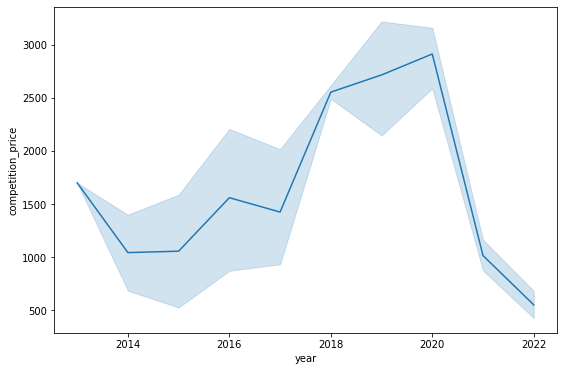

In [36]:
plt.figure(figsize=(9,6))

sns.lineplot(data=competition_price, x="year", y="competition_price")

In [37]:
#competition_price = competition_price.loc[competition_price['year']>=2022]
#competition_rating = competition_rating.loc[competition_rating['year']>=20]

To merge it was decided to do a group by ASIN and month to prevent big amount of null values when merging with our data. Even though ratings are not going to be precise they will give an estimate which can provide similar impact.

In [38]:
competition_rating = competition_rating.groupby(by = ['ASIN', 'month']).mean().reset_index()
#competition_price = competition_price.groupby(by = ['ASIN', 'year']).mean().reset_index()

In [39]:
competition_rating = competition_rating.drop(columns = ['day', 'year'])
#competition_price = competition_price.drop(columns = ['day', 'month'])

Here we can observe that competition ratings are not in the range of 0-5. This should be fixed. However, by doing standarization it might fix the problem as data is scaled. But is better to have them with the proper rating scale of 0-5.

In [40]:
competition_rating

,ASIN,month,competition_rating
0,B006B8JO98,1,18.700000
1,B006B8JO98,2,4.250000
2,B006B8JO98,3,16.480000
3,B006B8JO98,4,18.500000
4,B006B8JO98,5,14.825000
...,...,...,...
86,B09TBF4YBR,8,4.400000
87,B09TBF4YBR,9,4.433333
88,B09TBF4YBR,10,4.340000
89,B09TBF4YBR,11,4.350000


We merge competition ratings with our data by ASIN and month. Then a new column is created called competition_ratings.

In [41]:
df2 = pd.merge(df2, competition_rating, how = 'left', on = ['ASIN', 'month'])
#df2 = pd.merge(df2, competition_price, how = 'left', on = ['ASIN', 'year', 'month'])

In [42]:
df2

,Date,ASIN,TaxCode,Name,Qty,RegularPrice,Total Discount,Sale Price,Perc. Discount,Cost,day,week_of_year,month,month_start,month_end,year,quarter,Sales,rating,competition_rating
0,2019-01-13,B00FWSK1UE,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,2,57.84,0.000,57.840,0,23.52,13,2,1,False,False,2019,1,115.680,4.000000,NaN
1,2019-01-13,B00FYU5QRI,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,3,90.48,0.000,90.480,0,35.28,13,2,1,False,False,2019,1,271.440,4.300000,NaN
2,2019-01-13,B01N1YYIVZ,A_GEN_STANDARD,SD Codefree - Estuche que contiene Monitor de ...,6,290.04,0.000,290.040,0,46.00,13,2,1,False,False,2019,1,1740.240,4.600000,NaN
3,2019-01-14,B00FWSK1UE,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,1,28.92,0.000,28.920,0,11.76,14,3,1,False,False,2019,1,28.920,4.000000,NaN
4,2019-01-14,B00FYU5QRI,A_GEN_STANDARD,Codefree Kit SD - Medidor de glucosa en sangre...,1,30.16,0.000,30.160,0,11.76,14,3,1,False,False,2019,1,30.160,4.300000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,2022-07-23,B00FWSK1UE,A_HPC_SANITARYPRODUCTS,Codefree Kit SD - Medidor de glucosa en sangre...,1,24.54,0.000,24.540,0,11.76,23,29,7,False,False,2022,3,24.540,2.176111,11.326667
664,2022-07-25,B00FWSK1UE,A_HPC_SANITARYPRODUCTS,Codefree Kit SD - Medidor de glucosa en sangre...,1,24.54,0.000,24.540,0,11.76,25,30,7,False,False,2022,3,24.540,2.176111,11.326667
665,2022-07-28,B00FWSK1UE,A_HPC_SANITARYPRODUCTS,Codefree Kit SD - Medidor de glucosa en sangre...,1,24.54,2.454,22.086,10,11.76,28,30,7,False,False,2022,3,22.086,2.171667,11.326667
666,2022-07-29,B00FWSK1UE,A_HPC_SANITARYPRODUCTS,Codefree Kit SD - Medidor de glucosa en sangre...,1,24.54,0.000,24.540,0,11.76,29,30,7,False,False,2022,3,24.540,2.176111,11.326667


In [43]:
df2.isnull().sum()

Date                    0
ASIN                    0
TaxCode                 0
Name                    0
Qty                     0
RegularPrice            0
Total Discount          0
Sale Price              0
Perc. Discount          0
Cost                    0
day                     0
week_of_year            0
month                   0
month_start             0
month_end               0
year                    0
quarter                 0
Sales                   0
rating                  0
competition_rating    285
dtype: int64

We can see that during the merging there are 285 null values, this is because there was no matching for ASIN and months. This might be because not all ASIN from the competition are part of our ASIN's. To fix this instead of filling those null values with the mean, we predict them doing Machine Learning using a Random Forest Regressor Model. This will provide more diversified and precise values for competition Ratings.

In [44]:
#lg_n = LGBMRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
lg_n = RandomForestRegressor(n_estimators=100, random_state=42)
#df.head()
regression_df = df2.drop(columns = [ 'Date', 'Name'])
testdf = regression_df[regression_df['competition_rating'].isnull()==True]
traindf = regression_df[regression_df['competition_rating'].isnull()==False]
#testdf.shape
X_train_reg = traindf.drop(columns = ['competition_rating'])
y_train_reg = traindf['competition_rating']
X_test_reg = testdf.drop(columns = ['competition_rating'])
y_test_reg = testdf['competition_rating']
num_attribs = ['Perc. Discount', 'day', 'week_of_year', 'month', 'year', 'quarter', 'RegularPrice', 'Sale Price', 'Sales', 'rating']
dummy_attribs = ['month_start','month_end']
cat_attribs = ['ASIN', 'TaxCode']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat_encoder", OneHotEncoder(), dummy_attribs),
        ("cat", OrdinalEncoder(), cat_attribs)
    ])

X_train_reg_tr = full_pipeline.fit_transform(X_train_reg)
X_test_reg_tr = full_pipeline.fit_transform(X_test_reg)
lg_n.fit(X_train_reg_tr,y_train_reg)
pred = lg_n.predict(X_test_reg_tr)
testdf['competition_rating']= pred
list1 = []
index = (testdf.index)
list1 = index.append(list1)
df2.loc[list1,'competition_rating'] = testdf['competition_rating']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


After predicting the null values for competition ratings we can observe that there are no more null values. 

In [45]:
df2.isnull().sum()

Date                  0
ASIN                  0
TaxCode               0
Name                  0
Qty                   0
RegularPrice          0
Total Discount        0
Sale Price            0
Perc. Discount        0
Cost                  0
day                   0
week_of_year          0
month                 0
month_start           0
month_end             0
year                  0
quarter               0
Sales                 0
rating                0
competition_rating    0
dtype: int64

In [46]:
#not_null = df2.loc[df2['competition_rating'].isnull()== False]
#not_null['ASIN'].unique()    

##### Data Visualization

Before doing some Machine Learning we should understand first our Data. The best way to understand data is by visualizing. We can observe that increasing the prices also increases the sales.

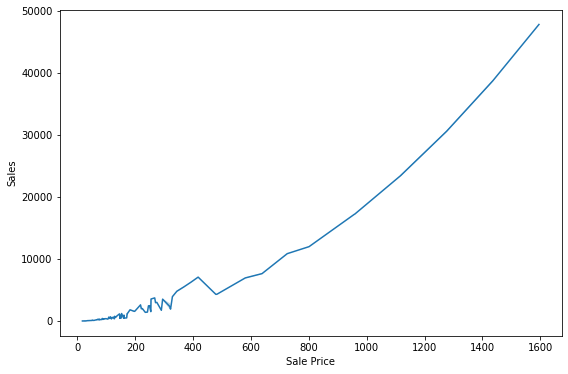

In [47]:
plt.figure(figsize=(9,6))

sns.lineplot(data=df2, x="Sale Price", y="Sales")

Here we can see that with the data we have that with no discounts Sales were bigger, however, the second with most sales was with the 30% discount.

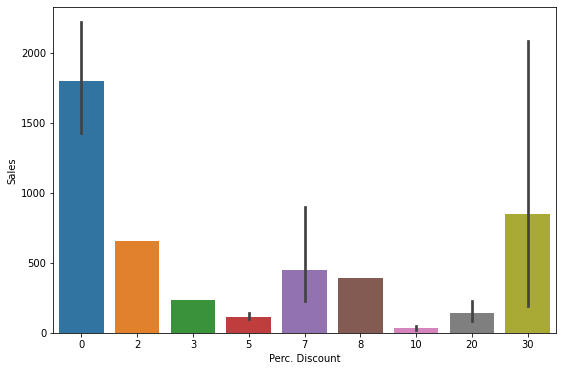

In [48]:
plt.figure(figsize=(9,6))

sns.barplot(data=df2, x="Perc. Discount", y="Sales")

With time series visualizations we can observe that Sales where really high in 2019, after that Sales dropped by a lot, starting to have more variation in year 2022.

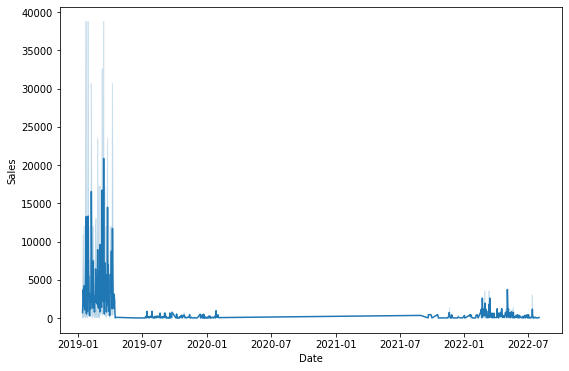

In [49]:
plt.figure(figsize=(9,6))

sns.lineplot(data=df2, x="Date", y="Sales")

The months that sales were bigger were at the first months of the year, being March the month with a higher amount of Sales.

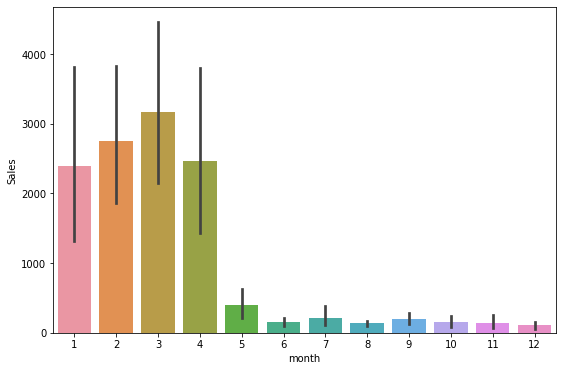

In [50]:
plt.figure(figsize=(9,6))

sns.barplot(data=df2, x="month", y="Sales")

For daily Sales, the results showed that the first week of each month had higher amount of sales.

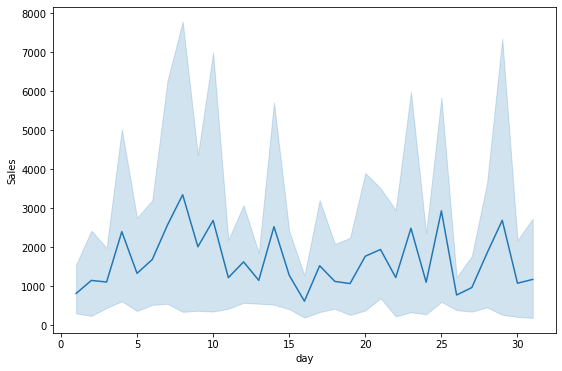

In [51]:
plt.figure(figsize=(9,6))

sns.lineplot(data=df2, x="day", y="Sales")

In [52]:
df2 = df2.drop(columns = ['Date', 'Name'])

#### Data Preprocessing

To start doing Machine Learning to predict Quantities Sold first we should do some Data Preprocessing. The first step is to split data into Training set and Test Set. We do a split of the data with a test set representing a 20% of the data.

In [53]:
train, test = train_test_split(df2, test_size = 0.2, random_state = 42)

In [54]:
train.head()

,ASIN,TaxCode,Qty,RegularPrice,Total Discount,Sale Price,Perc. Discount,Cost,day,week_of_year,month,month_start,month_end,year,quarter,Sales,rating,competition_rating
235,B01N1YYIVZ,A_HPC_SANITARYPRODUCTS,6,321.78,0.0,321.78,0,46.00,12,15,4,False,False,2019,2,1930.68,4.500000,4.551813
399,B00FYU5QRI,A_GEN_REDUCED,1,28.36,0.0,28.36,0,11.76,1,1,1,True,False,2020,1,28.36,3.750000,5.002608
602,B00FYU5QRI,A_HPC_SANITARYPRODUCTS,1,24.54,0.0,24.54,0,11.76,31,22,5,False,True,2022,2,24.54,4.579667,4.425000
61,B00FYU5QRI,A_HPC_SANITARYPRODUCTS,8,196.32,0.0,196.32,0,94.08,4,6,2,False,False,2019,1,1570.56,4.466667,28.250000
145,B00FYU5QRI,A_HPC_SANITARYPRODUCTS,7,171.78,0.0,171.78,0,82.32,7,10,3,False,False,2019,1,1202.46,4.500000,4.250000


In [55]:
train = train.reset_index()
train = train.drop(columns = ['index'])

When choosing the X and Y values. We drop Sales as they are dependent from quantities and Cost as they don't have impact on the predictions of Quantities. Y value is the Quantities.

In [56]:
X_train = train.drop(columns = ['Qty', 'Sales', 'Cost'])
X_test = test.drop(columns = ['Qty', 'Sales', 'Cost'])
y_train = train['Qty']
y_test = test['Qty']

Here we do some preprocessing such as One Hot Encoder for month_start and month_end as they are in a bool datatype, this will transform this values into 0 or 1. For ASIN and TaxCode we do an Ordinal Encoder to transform categories into a numerical value. For numerical features we have to scale data to improve results when doing Machine Learning, the scaling process chosen is Standarization.

In [57]:
num_attribs = ['Perc. Discount', 'day', 'week_of_year', 'month', 'year', 'quarter', 'RegularPrice', 'Sale Price', 'rating', 'competition_rating']
dummy_attribs = ['month_start','month_end']
cat_attribs = ['ASIN', 'TaxCode']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat_encoder", OneHotEncoder(), dummy_attribs),
        ("cat", OrdinalEncoder(), cat_attribs)
    ])

X_train_tr = full_pipeline.fit_transform(X_train)
X_test_tr = full_pipeline.fit_transform(X_test)

#### Model Evaluation

Before choosing our Machine Learning model we first have to do evaluations with different models. The project is a regression problem, therefore the choosen Models to evaluate are Linear Regression, LightGBM regressor, Random Forest Regressor and XGBoost Regressor. The one with the lowest mean squared error is the one that performs the best and we can choose to predict quantities. When evaluating we do a Cross Validation of 10 and a number of estimators for tree models of 100.

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_tr, y_train)

LinearRegression()

In [59]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [60]:
lin_scores = cross_val_score(lin_reg, X_train_tr, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1.86898121 2.07592294 2.28812169 1.37434345 1.94418238 1.22966536
 1.70056108 1.674033   1.60145976 1.46710809]
Mean: 1.7224378954623993
Standard deviation: 0.31020002347338077


In [61]:
# define model
lg = LGBMRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1)
lg.fit(X_train_tr, y_train)

LGBMRegressor(learning_rate=0.05)

In [62]:
lg_scores = cross_val_score(lg, X_train_tr, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lg_rmse_scores = np.sqrt(-lg_scores)
display_scores(lg_rmse_scores)

Scores: [1.72390843 1.5619185  0.52314859 1.77915553 2.5460679  0.81858535
 0.71125017 1.2021561  0.98060834 0.57940944]
Mean: 1.2426208329841777
Standard deviation: 0.6172820240517345


In [63]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_tr, y_train)

RandomForestRegressor(random_state=42)

In [64]:
forest_scores = cross_val_score(forest_reg, X_train_tr, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.5395969  0.57315889 0.21235017 0.20316022 0.73081887 0.35880567
 0.12992741 0.86476194 0.48616326 0.24146956]
Mean: 0.4340212882809472
Standard deviation: 0.23334355474379473


In [65]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 100, seed = 42)
xgb_r.fit(X_train_tr, y_train)

XGBRegressor(objective='reg:squarederror', seed=42)

In [66]:
xgb_scores = cross_val_score(xgb_r, X_train_tr, y_train,
                                scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [0.52744114 0.35472445 0.28863611 0.19389424 0.61821659 0.3892088
 0.25614825 0.6991738  0.54389837 0.28445475]
Mean: 0.4155796490211401
Standard deviation: 0.1620913406457341


In [67]:
X_train_tr.shape

(534, 16)

In [68]:
X_test_tr.shape

(134, 16)

In [69]:
input_shape = X_train_tr.shape[1]

### Model

The top performer models are Random Forest Regressor and XGBoost Regressor. The next step is to do some hyperparameter tuning to each model to see how can we improve the results by reducing prediction error. When choosing the best parameters for each model we are going to use Randomized Search CV which is a good optimizer.

#### Random Forest Hyptertuning ASIN

The first Hyperparameter tuning is for Random Forest Regressor, here the chosen parameters are number of estimators and max features. The optimizer will find the parameters that gives a lower prediction error. For number of estimators the optimizer will choose between 1 and 200. For max features the optimizer will choose between 1 and the amount of features in the Data. The model is going to be fitted based on the training set.

In [70]:
from scipy.stats import randint
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=(input_shape))}

In [71]:
rs = RandomizedSearchCV(
    estimator=forest_reg, param_distributions=param_distribs, 
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=20,
    refit=True,
    random_state=42,
    verbose=True,
    n_jobs=-1,
    pre_dispatch='2*n_jobs')

In [72]:
rs.fit(X_train_tr, y_train)
print('Best score reached: {} with params: {} '.format(rs.best_score_, rs.best_params_))

Fitting 20 folds for each of 50 candidates, totalling 1000 fits
Best score reached: -0.36424329752943685 with params: {'max_features': 15, 'n_estimators': 170} 


In [73]:
asin_best_model_rf = rs.best_estimator_

After optimizing with Randomized Search CV we select the best parameters for the model and we can do predictions based on the test set.

In [74]:
asin_test_set_predictions_rf = asin_best_model_rf.predict(X_test_tr).flatten()

We can visualize the model performance. Also we can observe the error in predictions, and % of accuracy of the model. For error we can use as indicator Root Mean Squared Percentage Error and Root Mean Squared Error. For % accuracy we can use Coefficient of Determination or create a function that gives % accuracy of the model based on Mean Absolute Error. The last one is the one that gives a better understanding of the Model Performance.

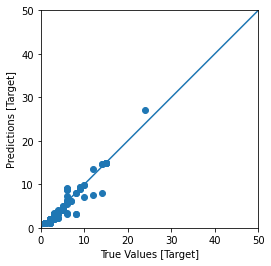

In [75]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, asin_test_set_predictions_rf)
plt.xlabel('True Values [Target]')
plt.ylabel('Predictions [Target]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [76]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [77]:
rmspe(y_test, asin_test_set_predictions_rf)

0.20773571829215065

In [78]:
mean_squared_error(y_test, asin_test_set_predictions_rf, squared=False)

1.2488036934081077

In [79]:
R_square = r2_score(y_test, asin_test_set_predictions_rf) 
print('Coefficient of Determination', R_square) 

Coefficient of Determination 0.907318291057336


In [80]:
def evaluate(model, X_test, y_test) :
    prediction = asin_best_model_rf.predict(X_test_tr).flatten()
    error = abs(prediction - y_test)
    mape = 100 * np.mean(error/y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
random_model = asin_best_model_rf
evaluate(random_model, X_test_tr, y_test)

Model Performance
Accuracy = 88.44%.


88.44341318616999

#### XGBoost Regressor Hypertuning

Another model that performed good was XGBoost Regressor, now we are going to do some Hyerparameter tuning to see if we can improve the performance. To select the best parameters we are also going to use Randomized Search CV optimizer.

In [81]:
params = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

In [82]:
x_rc = RandomizedSearchCV(
    estimator=xgb_r, param_distributions=params, 
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=20,
    refit=True,
    random_state=42,
    verbose=True,
    n_jobs=-1,
    pre_dispatch='2*n_jobs')

In [83]:
x_rc.fit(X_train_tr, y_train)
print('Best score reached: {} with params: {} '.format(rs.best_score_, rs.best_params_))

Fitting 20 folds for each of 50 candidates, totalling 1000 fits
Best score reached: -0.36424329752943685 with params: {'max_features': 15, 'n_estimators': 170} 


In [84]:
asin_best_model_xg = x_rc.best_estimator_

After optimizing with Randomized Search CV we select the best parameters for the model and we can do predictions based on the test set.

In [85]:
asin_test_set_predictions_xg = asin_best_model_xg.predict(X_test_tr).flatten()

We can visualize the model performance. Also we can observe the error in predictions, and % of accuracy of the model. For error we can use as indicator Root Mean Squared Percentage Error and Root Mean Squared Error. For % accuracy we can use Coefficient of Determination or create a function that gives % accuracy of the model based on Mean Absolute Error. The last one is the one that gives a better understanding of the Model Performance.

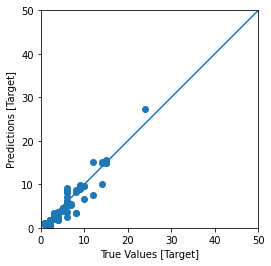

In [86]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, asin_test_set_predictions_xg)
plt.xlabel('True Values [Target]')
plt.ylabel('Predictions [Target]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [87]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [88]:
rmspe(y_test, asin_test_set_predictions_xg)

0.2537502235803575

In [89]:
mean_squared_error(y_test, asin_test_set_predictions_xg, squared=False)

1.2723045535479438

In [90]:
R_square = r2_score(y_test, asin_test_set_predictions_xg) 
print('Coefficient of Determination', R_square) 

Coefficient of Determination 0.9037971701743516


In [119]:
def evaluate(model, X_test, y_test) :
    prediction = asin_best_model_xg.predict(X_test_tr).flatten()
    error = abs(prediction - y_test)
    mape = 100 * np.mean(error/y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
random_model = asin_best_model_xg
evaluate(random_model, X_test_tr, y_test)

Model Performance
Accuracy = 83.10%.


83.0969914385519

#### Discount Selection

After choosing the Model (Random Forest Regressor) and doing Hyperparameter tuning to improve the performance when predicting Quantities. We can start doing simulations for the Discount Selection. In the simulation the first step is to choose values for the X features to predict Quantities. After predicting Quantities sold we can create new columns to observe profit when applying different Discounts. There are different strategies to choose the best discounts based on a certain date, ASIN, TaxCode, regular price, rating and competition rating. These strategies can be Price Elasticity of Demand or Purchase Rate based on Volume. Now the only one we can try is with Price Elasticity of Demand.

In [146]:
date = pd.date_range(start='03/01/2022', end='06/01/2022').strftime("%m-%d-%Y").tolist()
asin = 'B00FWSK1UE'
taxcode = 'A_GEN_STANDARD'
regular_price = 57.84
competition_rating = 4.5
zero = np.array([0])
discount_perc = np.arange(10,36)
discount_perc = np.append(zero, discount_perc)
discount_perc = np.array(discount_perc)
rating = 4
#total_discount = regular_price * (discount_perc/100)
#sale_price = regular_price - total_discount
cost = 20

When doing the simulation we choose a range of Dates, an ASIN, a TaxCode, a Regular Price, rating, Competition Rating and a range of different discounts, as the purpose of the project is to choose discounts with a max of 35% we simulate with ranges of discounts from 0 to 35. We can choose a fix value of cost to calculate profit.

In [147]:
discount_perc

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [148]:
discount_shape = discount_perc.shape[0]

In [149]:
date = np.repeat(date, discount_shape)

In [150]:
columns = {'Date': date}
date = pd.DataFrame(data = columns)

In [151]:
date.head()

,Date
0,03-01-2022
1,03-01-2022
2,03-01-2022
3,03-01-2022
4,03-01-2022


In [152]:
#date = [date[i:i+1] for i in range(0, len(date), 1)]
#date

In [153]:
discount_perc = discount_perc.tolist()
#total_discount = total_discount.tolist()
#sale_price = sale_price.tolist()

In [154]:
count_unique_dates = date['Date'].nunique()
count_unique_dates

93

In [155]:
date['Perc. Discount'] = discount_perc * count_unique_dates

In [156]:
maximization = date.copy()

In [157]:
#discount_perc = pd.DataFrame(discount_perc)
#total_discount = pd.DataFrame(total_discount)
#sale_price = pd.DataFrame(sale_price)

The first step is to create a Dataframe with the same X features as our training dataset. The reason for this is to be able to predict quantities sold. The Dataframe will include all the values used in the simulation.

In [158]:
maximization = pd.DataFrame(maximization)

In [159]:
#maximization['Perc. Discount'] = discount_perc
#maximization['Date'] = date
maximization['ASIN'] = [asin][0]    
maximization['TaxCode'] = [taxcode][0]
maximization['RegularPrice'] = [regular_price][0]
maximization['Total Discount'] = maximization['RegularPrice'] * (maximization['Perc. Discount']/100)
maximization['Sale Price'] = maximization['RegularPrice'] - maximization['Total Discount']
maximization['competition_rating'] = [competition_rating][0]
#maximization['Cost'] = [cost][0]

In [160]:
maximization['Date'] = pd.to_datetime(maximization['Date'])
maximization['day'] = maximization['Date'].dt.day
maximization['week_of_year'] = maximization['Date'].dt.isocalendar().week
maximization['month'] = maximization['Date'].dt.month
maximization['month_start'] = maximization['Date'].dt.is_month_start
maximization['month_end'] = maximization['Date'].dt.is_month_end
maximization['year'] = maximization['Date'].dt.year
maximization['quarter'] = maximization['Date'].dt.quarter
maximization['rating'] = [rating][0] 

In [161]:
X_train.columns

Index(['ASIN', 'TaxCode', 'RegularPrice', 'Total Discount', 'Sale Price',
       'Perc. Discount', 'day', 'week_of_year', 'month', 'month_start',
       'month_end', 'year', 'quarter', 'rating', 'competition_rating'],
      dtype='object')

Here we order the columns so there is no problem when predicting.

In [162]:
maximization = maximization[['Date', 'ASIN', 'TaxCode', 'RegularPrice', 'Total Discount', 'Sale Price',
       'Perc. Discount', 'day', 'week_of_year', 'month', 'month_start', 'month_end',
       'year', 'quarter', 'rating', 'competition_rating']]   

In [163]:
maximization = maximization.drop(columns =  ['Date'])

In [164]:
maximization_tr = full_pipeline.fit_transform(maximization)

Here we predict quantities.

In [165]:
asin_max_set_predictions_rf = asin_best_model_rf.predict(maximization_tr).flatten()

After predicting quantities we can start creating new columns for analysis purposes. We can create one for sales, cost and profit.

In [166]:
maximization['Total Discount'] = maximization['RegularPrice'] * (maximization['Perc. Discount']/100)

In [167]:
maximization['Qty'] = asin_max_set_predictions_rf

In [168]:
maximization['Sales'] = maximization['Qty'] * maximization['Sale Price']
#maximization['revenue_discount'] = maximization['Sale Price'] * maximization['Qty']
#maximization['revenue'] = (maximization['RegularPrice'] * maximization['Qty'])
maximization['Cost'] = [cost][0]
maximization['profit'] = maximization ['Sales'] - (maximization['Cost'] * maximization['Qty'])
#maximization['profit_discount'] = maximization ['revenue_discount'] - (maximization['Cost'] * maximization['Qty'])
#maximization['profit_gain'] = maximization['profit_discount'] - maximization['profit']

To do a simulation for a centain month we can do a group by, this simulation will help you choose which is going to be the best discount for a certain month in the year.

In [169]:
maximization = maximization.groupby(by = ['month', 'Perc. Discount']).agg({'Sale Price': 'mean', 'Qty': 'sum',
                                                                           'Sales': 'sum', 'Cost': 'sum', 'profit': 'sum'}).reset_index()
#maximization_mes[['month', 'Perc. Discount', 'Sale Price', 'Qty', 'Sales', 'Cost', 'profit']]

In [170]:
maximization_mes = maximization.loc[maximization['month']< maximization['month'].max()]

After doing the predictions of quantities sold and creating new columns we can start applying the strategy chosen for discount selection. The following strategy is Price Elasticity of Demand. Price elasticity of demand is the ratio of the percentage change in quantity demanded of a product to the percentage change in price. Economists employ it to understand how supply and demand change when a product's price changes. When Price Elasticity of Demand if greater or equal to 1 that means that demand is elastic, demand will be very sensitive to the change of prices. If price elasticity of demand is closer to 0 that means that demand is inelastic, when prices change demand is less sensitive to that change in prices. When Price elasticity of demand is 0 that means that is perfectly inelastic, meaning there is no change in demand when prices change. This is a good strategy when choosing discounts as it will tell how will customers will react when a discount is applied. However, other strategies can be used such as Purchase Rate, but to do this we need volume of people searching the product. How will the customer react to each discount?

In [171]:
maximization_mes = maximization_mes.loc[(maximization_mes['month'] == 5) & (maximization_mes['Perc. Discount'] > 0)]
maximization_mes["% Change in Demand"] = maximization_mes["Qty"].pct_change()
maximization_mes["% Change in Price"] = maximization_mes["Sale Price"].pct_change()
maximization_mes['price_elasticity'] = maximization_mes["% Change in Demand"] / maximization_mes["% Change in Price"]


In [173]:
maximization_mes

,month,Perc. Discount,Sale Price,Qty,Sales,Cost,profit,% Change in Demand,% Change in Price,price_elasticity
55,5,10,52.0560,274.800000,14304.988800,620,8808.988800,NaN,NaN,NaN
56,5,11,51.4776,275.905882,14202.972649,620,8684.855002,0.004024,-0.011111,-0.362189
57,5,12,50.8992,278.100000,14155.067520,620,8593.067520,0.007952,-0.011236,-0.707765
58,5,13,50.3208,275.982353,13887.652786,620,8368.005727,-0.007615,-0.011364,0.670093
59,5,14,49.7424,273.135294,13586.405054,620,8123.699172,-0.010316,-0.011494,0.897500
60,5,15,49.1640,265.811765,13068.369600,620,7752.134306,-0.026813,-0.011628,2.305903
61,5,16,48.5856,250.041176,12148.400584,620,7147.577054,-0.059330,-0.011765,5.043042
62,5,17,48.0072,240.100000,11526.528720,620,6724.528720,-0.039758,-0.011905,3.339685
63,5,18,47.4288,231.576471,10983.394108,620,6351.864696,-0.035500,-0.012048,2.946493
64,5,19,46.8504,220.005882,10307.363591,620,5907.245944,-0.049964,-0.012195,4.097084


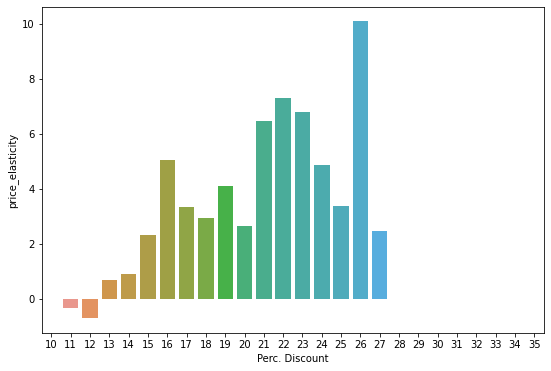

In [172]:
plt.figure(figsize=(9,6))

sns.barplot(data=maximization_mes, x="Perc. Discount", y="price_elasticity")